In [1]:
import os
import matplotlib.pyplot as plt
from preprocessing import *
# %pip install fasttext-wheel
from lstm import *
from crf import create_bio_tags

ROOT_DIR = os.path.dirname(os.path.abspath(""))

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
ft = load_fasttext()

In [13]:
model = LSTM(
	model_path=os.path.join(ROOT_DIR, "models", "lstm_0_2.pt"),
	device=device,
	hyperparams={
		"input_dim": 617,
		"hidden_dim": 300,
		"num_layers": 2,
		"output_dim": 9,
		"seq_len": 10,
		"epochs": 1,
		"batch_size": 32,
		"learning_rate": 1e-3,
		"num_workers": 12,
		"dataset_type": "overlapping",
	},
	ft=ft,
	verbose=True,
)

Preparing training set...
Training model...
Epoch [1/1], Batch [5705/5705], Loss: 0.0029780582990497354


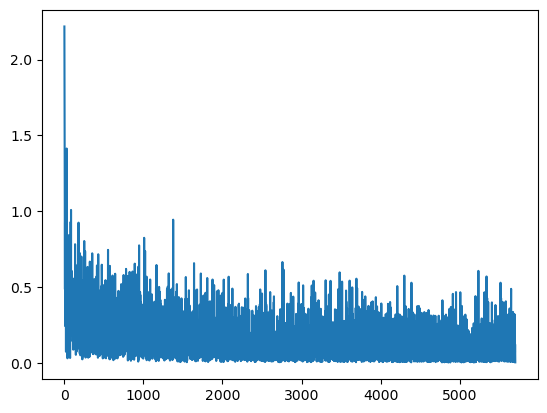

In [14]:
losses = model.train(
	train_tokens_path=os.path.join(ROOT_DIR, "data", "training_data_tokens.json"),
	train_lemmas_path=os.path.join(ROOT_DIR, "data", "training_data_lemmas.json"),
	train_pos_path=os.path.join(ROOT_DIR, "data", "training_data_pos.json"),
	train_labels_path=os.path.join(ROOT_DIR, "data", "training_data_bio.json"),
	frac=1.0
)
plt.plot(losses)

In [15]:
model.save()

In [18]:
loss, accuracy = model.evaluate(
	test_tokens_path=os.path.join(ROOT_DIR, "data", "test_data_tokens.json"),
	test_lemmas_path=os.path.join(ROOT_DIR, "data", "test_data_lemmas.json"),
	test_pos_path=os.path.join(ROOT_DIR, "data", "test_data_pos.json"),
	test_labels_path=os.path.join(ROOT_DIR, "data", "test_data_bio.json"),
	frac=1.0
)

Preparing test set...


100%|██████████| 1479/1479 [00:09<00:00, 153.05it/s]

Test Loss: 0.1081, Test Accuracy: 0.9694


In [16]:
pred = model.predict(
	["vejiga", "de", "correcta", "capacidad", "250", "cc", "de", "contraste", "de", "paredes", "trabeculadas", "y", "con", "diverticulos", "el", "mayor", "de", "ellos", "en", "cara", "posterolateral", "izquierda", "sin", "observarse", "defectos", "de", "replecion"],
	["vejiga", "de", "correcto", "capacidad", "250", "cc", "de", "contraste", "de", "pared", "trabeculada", "y", "con", "diverticulo", "el", "mayor", "de", "\u00e9l", "en", "cara", "posterolateral", "izquierdo", "sin", "observar \u00e9l", "defecto", "de", "replecion"],
	["NOUN", "ADP", "ADJ", "NOUN", "NUM", "NUM", "ADP", "NOUN", "ADP", "NOUN", "ADJ", "CCONJ", "ADP", "NOUN", "DET", "ADJ", "ADP", "PRON", "ADP", "NOUN", "ADJ", "ADJ", "ADP", "VERB", "PRON", "NOUN", "ADP", "PROPN"],
)

In [17]:
print(pred)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NEG', 'B-NSCO', 'I-NSCO', 'I-NSCO', 'I-NSCO']


---

In [52]:
class NegationDetectionModel(nn.Module):
	def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
		super(NegationDetectionModel, self).__init__()
		
		# BiLSTM Layer
		self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional=True, batch_first=True)
		# Dense Layer
		self.fc = nn.Linear(hidden_dim * 2, output_dim)
		
	def forward(self, word_embeds):
		lstm_out, _ = self.bilstm(word_embeds)
		out = self.fc(lstm_out)
		return out
	
model = NegationDetectionModel(617, 300, 2, 9)

In [53]:
# example inference
word_embeds = torch.randn(32, 10, 617)
out = model(word_embeds)
print(out.shape)

torch.Size([32, 10, 9])


In [58]:
bilstm = nn.LSTM(617, 300, 2, bidirectional=True, batch_first=True)
fc = nn.Linear(300 * 2, 9)

In [55]:
bilstm_out, _ = bilstm(word_embeds)

In [57]:
bilstm_out.shape

torch.Size([32, 10, 600])

In [63]:
forward_last = bilstm_out[:, -1, :300]
backward_last = bilstm_out[:, 0, 300:]
concat = torch.cat((forward_last, backward_last), dim=1)
concat.shape

torch.Size([32, 600])

In [64]:
out = fc(concat)
out.shape

torch.Size([32, 9])